# Predicting coronary heart disease with the SVN and Random Forest ML algorithms

Dataset acquired from: https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction

## Import necessary Libraries

In [258]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sc
import sklearn as sk
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from matplotlib import pyplot as plt
import seaborn as sns


## Acquire the dataset

In [223]:
file_path = 'heart.csv'

# Read the CSV file into a DataFrame
df = pd.read_csv(file_path, sep=',')

# Display the DataFrame
df.head()


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.00,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.00,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.00,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.50,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.00,Up,0


Features are all columns (Age, Sex etc.) except for the HeartDisease column which is the Target.

## Explore the dataset

In [224]:
df.shape

(918, 12)

In [225]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


We will need to transform the columns below (categorical features):

Sex

ChestPainType

RestingECG

ExerciseAngina

ST_Slope

Check if there are null values

In [226]:
df.isnull().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

No null values detected, we will need to check for false values or outliers later though

All features seem to be relevant and might be possible predictors for coronary heart disease. (medical expert's opinion might be helpful here)

In [227]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Age,918.00,53.51,9.43,28.00,47.00,54.00,60.00,77.00
RestingBP,918.00,132.40,18.51,0.00,120.00,130.00,140.00,200.00
Cholesterol,918.00,198.80,109.38,0.00,173.25,223.00,267.00,603.00
FastingBS,918.00,0.23,0.42,0.00,0.00,0.00,0.00,1.00
MaxHR,918.00,136.81,25.46,60.00,120.00,138.00,156.00,202.00
Oldpeak,918.00,0.89,1.07,-2.60,0.00,0.60,1.50,6.20
HeartDisease,918.00,0.55,0.50,0.00,0.00,1.00,1.00,1.00


In [228]:
df['HeartDisease'].value_counts(normalize=True)

HeartDisease
1   0.55
0   0.45
Name: proportion, dtype: float64

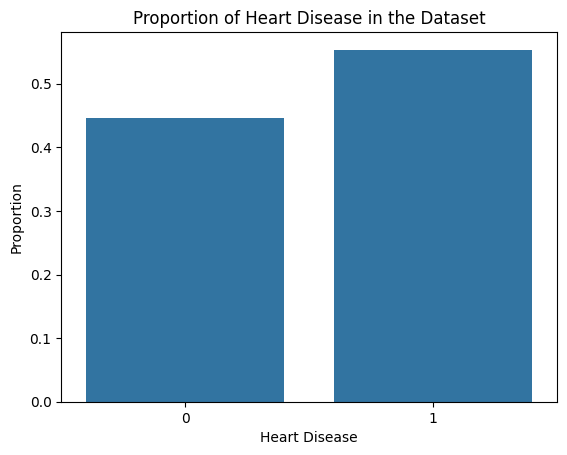

In [259]:
normalized_counts = df['HeartDisease'].value_counts(normalize=True)

# Create a bar plot using Seaborn
sns.barplot(x=normalized_counts.index, y=normalized_counts.values)

# Add labels and title
plt.xlabel('Heart Disease')
plt.ylabel('Proportion')
plt.title('Proportion of Heart Disease in the Dataset')

plt.show()

With some more medical knowledge we could make some visualizations to detect possible outliers and then remove them
or replace extreme outliers with a maximum or minimum threshold (capping or flooring).
For example, if data points are beyond the 95th percentile, set them to the 95th percentile value. This could prove helpful for our model, making it more generally applicable.

### Transforming text to integers (one hot encoding)

We want to change the categorical variables to numerical values

In [230]:
categorical_columns = ['Sex',
                      'ChestPainType',
                      'RestingECG',
                      'ExerciseAngina',
                      'ST_Slope']
print('-----------------------------')
for column in categorical_columns:
    unique_values = df[column].unique()
    print(f'Unique {column} values:')
    for value in unique_values:
        print(f' - {value}')
    print('-----------------------------')

-----------------------------
Unique Sex values:
 - M
 - F
-----------------------------
Unique ChestPainType values:
 - ATA
 - NAP
 - ASY
 - TA
-----------------------------
Unique RestingECG values:
 - Normal
 - ST
 - LVH
-----------------------------
Unique ExerciseAngina values:
 - N
 - Y
-----------------------------
Unique ST_Slope values:
 - Up
 - Flat
 - Down
-----------------------------


All unique categorical feature values seem to be valid so we don't need to do any imputation for the categorical features

## Feature Imputation & Standardization

first, check if there are any false values depending on the feature

In [231]:
# Ensure all specified columns contain only positive values
columns_to_check = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR']

# Loop through each column to count non-positive entries
for column in columns_to_check:
    count_of_non_positive_values = (df[column] <= 0).sum()
    print(f'Number of non-positive entries in {column}: {count_of_non_positive_values}')

Number of non-positive entries in Age: 0
Number of non-positive entries in RestingBP: 1
Number of non-positive entries in Cholesterol: 172
Number of non-positive entries in MaxHR: 0


In [232]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [233]:
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.00,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.00,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.00,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.50,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.00,Up,0


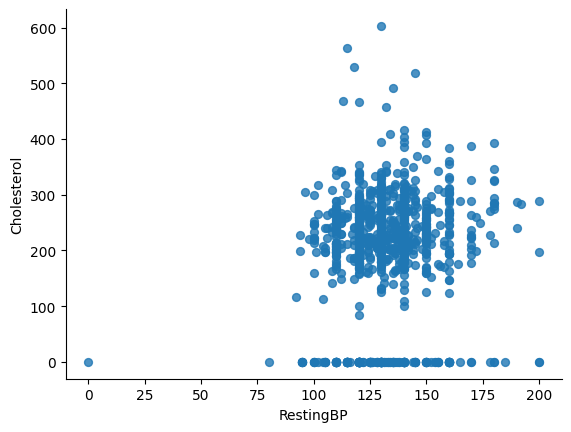

In [234]:
df.plot(kind='scatter', x='RestingBP', y='Cholesterol', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

Pick categorical and numerical features

In [235]:
categorical_columns = ['Sex',
                      'ChestPainType',
                      'RestingECG',
                      'ExerciseAngina',
                      'ST_Slope']
numerical_columns = [col for col in df.columns.tolist() if col not in categorical_columns and col != 'HeartDisease']

Replace zeros with NaN in 'RestingBP' and 'Cholesterol' columns before converting to numeric types to ensure that zeros do not affect the mean calculation.


In [236]:
df['RestingBP'] = pd.to_numeric(df['RestingBP'].replace(0, pd.NA), errors='coerce')
df['Cholesterol'] = pd.to_numeric(df['Cholesterol'].replace(0, pd.NA), errors='coerce')

In [237]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       917 non-null    float64
 4   Cholesterol     746 non-null    float64
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 86.2+ KB


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140.00,289.00,0,Normal,172,N,0.00,Up,0
1,49,F,NAP,160.00,180.00,0,Normal,156,N,1.00,Flat,1
2,37,M,ATA,130.00,283.00,0,ST,98,N,0.00,Up,0
3,48,F,ASY,138.00,214.00,0,Normal,108,Y,1.50,Flat,1
4,54,M,NAP,150.00,195.00,0,Normal,122,N,0.00,Up,0


Create transformers for numerical and categorical data

In [238]:
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Impute missing values
    ('scaler', StandardScaler())  # Scale data
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Impute missing values (none in this case)
    ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))  # One-hot encode
])

Combine transformers into a preprocessor

In [239]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_columns),
        ('cat', categorical_transformer, categorical_columns)
    ]
)

Split the data into training, validation and testing sets

In [240]:
X = df.drop("HeartDisease", axis=1)
y = df["HeartDisease"]

# adding validation dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Apply all the preprocessing to the data after splitting it to prevent data leakage

In [241]:
X_train_prepared = preprocessor.fit_transform(X_train)
X_test_prepared = preprocessor.transform(X_test)
X_val_prepared = preprocessor.transform(X_test)
X_train_prepared.shape, X_test_prepared.shape, X_val_prepared.shape

((734, 20), (184, 20), (184, 20))

In [242]:
model = RandomForestClassifier()

In [243]:
model.fit(X_train_prepared, y_train)

RandomForestClassifier()

In [244]:
y_preds = model.predict(X_test_prepared)

In [245]:
model.score(X_train_prepared, y_train)

1.0

In [246]:
model.score(X_test_prepared, y_test)

0.8858695652173914

## SVM

Define the SVM model and parameter grid

In [247]:
svm_model = SVC()
param_grid_svm = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
}

Setting up Grid Search CV for SVM using 5-fold cross-validation

The scoring metric we will use is 'accuracy'

In [248]:
grid_search_svm = GridSearchCV(estimator=svm_model, param_grid=param_grid_svm, cv=5, scoring='accuracy', verbose=2)

In [255]:
grid_search_svm.get_params()

{'cv': 5,
 'error_score': nan,
 'estimator__C': 1.0,
 'estimator__break_ties': False,
 'estimator__cache_size': 200,
 'estimator__class_weight': None,
 'estimator__coef0': 0.0,
 'estimator__decision_function_shape': 'ovr',
 'estimator__degree': 3,
 'estimator__gamma': 'scale',
 'estimator__kernel': 'rbf',
 'estimator__max_iter': -1,
 'estimator__probability': False,
 'estimator__random_state': None,
 'estimator__shrinking': True,
 'estimator__tol': 0.001,
 'estimator__verbose': False,
 'estimator': SVC(),
 'n_jobs': None,
 'param_grid': {'C': [0.1, 1, 10, 100],
  'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
 'pre_dispatch': '2*n_jobs',
 'refit': True,
 'return_train_score': False,
 'scoring': 'accuracy',
 'verbose': 2}

In [250]:
# Fit Grid Search to the training data
grid_search_svm.fit(X_train_prepared, y_train)

# Print best parameters and best score
print("Best parameters:", grid_search_svm.best_params_)
print("Best cross-validation accuracy:", grid_search_svm.best_score_)

# Evaluate on the validation set
best_svm = grid_search_svm.best_estimator_
validation_accuracy = best_svm.score(X_test_prepared, y_test)
print("Test accuracy:", validation_accuracy)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END ...............................C=0.1, kernel=linear; total time=   0.0s
[CV] END ...............................C=0.1, kernel=linear; total time=   0.0s
[CV] END ...............................C=0.1, kernel=linear; total time=   0.0s
[CV] END ...............................C=0.1, kernel=linear; total time=   0.0s
[CV] END ...............................C=0.1, kernel=linear; total time=   0.0s
[CV] END .................................C=0.1, kernel=poly; total time=   0.0s
[CV] END .................................C=0.1, kernel=poly; total time=   0.0s
[CV] END .................................C=0.1, kernel=poly; total time=   0.0s
[CV] END .................................C=0.1, kernel=poly; total time=   0.0s
[CV] END .................................C=0.1, kernel=poly; total time=   0.0s
[CV] END ..................................C=0.1, kernel=rbf; total time=   0.0s
[CV] END ..................................C=0.1

The best parameters found were C=1 and kernel='rbf', which suggests that a radial basis function kernel with a moderate regularization strength (C=1) work best for our dataset.

Parameter Expansion: Considering other C values beyond the provided grid or adjusting other SVM parameters like gamma for the RBF kernel might help.


## Random Forest

In [251]:
# Define the Random Forest model and parameter grid
rf_model = RandomForestClassifier(random_state=42)
param_grid_rf = {
    'n_estimators': [100, 200, 300, 400, 500, 600],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Setting up Grid Search CV for Random Forest
grid_search_rf = GridSearchCV(estimator=rf_model, param_grid=param_grid_rf, cv=5, scoring='accuracy', verbose=2)

# Output setup for verification before execution
grid_search_rf.get_params()

{'cv': 5,
 'error_score': nan,
 'estimator__bootstrap': True,
 'estimator__ccp_alpha': 0.0,
 'estimator__class_weight': None,
 'estimator__criterion': 'gini',
 'estimator__max_depth': None,
 'estimator__max_features': 'sqrt',
 'estimator__max_leaf_nodes': None,
 'estimator__max_samples': None,
 'estimator__min_impurity_decrease': 0.0,
 'estimator__min_samples_leaf': 1,
 'estimator__min_samples_split': 2,
 'estimator__min_weight_fraction_leaf': 0.0,
 'estimator__n_estimators': 100,
 'estimator__n_jobs': None,
 'estimator__oob_score': False,
 'estimator__random_state': 42,
 'estimator__verbose': 0,
 'estimator__warm_start': False,
 'estimator': RandomForestClassifier(random_state=42),
 'n_jobs': None,
 'param_grid': {'n_estimators': [100, 200, 300, 400, 500, 600],
  'max_features': ['auto', 'sqrt', 'log2']},
 'pre_dispatch': '2*n_jobs',
 'refit': True,
 'return_train_score': False,
 'scoring': 'accuracy',
 'verbose': 2}

In [252]:
# Fit Grid Search to the training data
grid_search_rf.fit(X_train_prepared, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END ................max_features=auto, n_estimators=100; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END ................max_features=auto, n_estimators=100; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END ................max_features=auto, n_estimators=100; total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END ................max_features=auto, n_estimators=100; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END ................max_features=auto, n_estimators=100; total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END ................max_features=auto, n_estimators=200; total time=   1.1s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END ................max_features=auto, n_estimators=200; total time=   2.2s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END ................max_features=auto, n_estimators=200; total time=   1.0s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END ................max_features=auto, n_estimators=200; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END ................max_features=auto, n_estimators=200; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END ................max_features=auto, n_estimators=300; total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END ................max_features=auto, n_estimators=300; total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END ................max_features=auto, n_estimators=300; total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END ................max_features=auto, n_estimators=300; total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END ................max_features=auto, n_estimators=300; total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END ................max_features=auto, n_estimators=400; total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END ................max_features=auto, n_estimators=400; total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END ................max_features=auto, n_estimators=400; total time=   0.9s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END ................max_features=auto, n_estimators=400; total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END ................max_features=auto, n_estimators=400; total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END ................max_features=auto, n_estimators=500; total time=   1.1s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END ................max_features=auto, n_estimators=500; total time=   1.1s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END ................max_features=auto, n_estimators=500; total time=   1.5s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END ................max_features=auto, n_estimators=500; total time=   1.5s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END ................max_features=auto, n_estimators=500; total time=   1.0s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END ................max_features=auto, n_estimators=600; total time=   1.3s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END ................max_features=auto, n_estimators=600; total time=   1.2s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END ................max_features=auto, n_estimators=600; total time=   1.2s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END ................max_features=auto, n_estimators=600; total time=   1.2s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END ................max_features=auto, n_estimators=600; total time=   1.2s
[CV] END ................max_features=sqrt, n_estimators=100; total time=   0.2s
[CV] END ................max_features=sqrt, n_estimators=100; total time=   0.2s
[CV] END ................max_features=sqrt, n_estimators=100; total time=   0.2s
[CV] END ................max_features=sqrt, n_estimators=100; total time=   0.2s
[CV] END ................max_features=sqrt, n_estimators=100; total time=   0.2s
[CV] END ................max_features=sqrt, n_estimators=200; total time=   0.4s
[CV] END ................max_features=sqrt, n_estimators=200; total time=   0.4s
[CV] END ................max_features=sqrt, n_estimators=200; total time=   0.4s
[CV] END ................max_features=sqrt, n_estimators=200; total time=   0.5s
[CV] END ................max_features=sqrt, n_estimators=200; total time=   0.6s
[CV] END ................max_features=sqrt, n_estimators=300; total time=   0.9s
[CV] END ................max

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [100, 200, 300, 400, 500, 600]},
             scoring='accuracy', verbose=2)

In [254]:
# Print best parameters and best score
print("Best parameters found:", grid_search_rf.best_params_)
print("Best cross-validation accuracy:", grid_search_rf.best_score_)

# Evaluate on the test set
test_accuracy = grid_search_rf.best_estimator_.score(X_test_prepared, y_test)
print("Test accuracy:", test_accuracy)


Best parameters found: {'max_features': 'auto', 'n_estimators': 500}
Best cross-validation accuracy: 0.8582890690522784
Test accuracy: 0.8913043478260869


Further analysis might be useful. Evaluating the model based on other metrics could make it better for our use case. (false negatives or false positives could be detrimental in medical diagnosis)

Analyzing which features are most important could also provide insights into heart disease causes.

